In [3]:
import os
import openai
from llama_index import Document
from llama_index import SimpleDirectoryReader
from llama_index import VectorStoreIndex
from llama_index import ServiceContext

from llama_index.llms import OpenAI
from configparser import ConfigParser
import pandas as pd
from trulens_eval import Tru
from trulens_eval import TruLlama
pd.set_option('display.max_colwidth', -1)

/tmp/ipykernel_273/513349570.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
# ! pip install openai

In [ ]:
# !pip install llama_index

In [ ]:
# !pip install --upgrade pydantic==1.10.0 typing-extensions==4.5.0

In [ ]:
# !pip install pypdf

In [ ]:
# !pip install trulens_eval

In [ ]:
# !pip install protobuf==3.20

## OpenAI key

In [4]:
config=ConfigParser()
config.read('conf/conf.ini')
openai.api_key = config['openai']['apikey']

In [5]:
os.environ["OPENAI_API_KEY"] = config['openai']['apikey']

In [6]:
from src.utils import build_sentence_window_index
from src.utils import get_prebuilt_trulens_recorder
from src.utils import get_sentence_window_query_engine

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input response will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


## Load data

In [7]:
documents = SimpleDirectoryReader(
    input_files=["data/raw/Advokatuuriseadus–Riigi Teataja.pdf"]
).load_data()

In [8]:
print(type(documents), "\n")
print(len(documents), "\n")
print(type(documents[0]))
print(documents[0])

<class 'list'> 

21 

<class 'llama_index.schema.Document'>
Doc ID: 09f6ad9a-d0fd-48fe-a298-586032128386
Text: 12/4/23, 7:36 PM Advokatuuriseadus–Riigi Teataja
https://www.riigiteataja.ee/akt/921782?leiaKehtiv 1/21Väljaandja:
Riigikogu Akti liik: seadus Teksti liik: terviktekst Redaktsiooni
jõustumise kp: 01.02.2023 Redaktsiooni kehtivuse lõpp: Hetkel kehtiv
Avaldamismärge: RT I, 05.05.2022, 5 Advokatuuriseadus Vastu võetud
21.03.2001 RT I 2001, 36, 201 ...


## RAG pipeline

In [9]:
document = Document(text="\n\n".join([doc.text for doc in documents]))

In [33]:
# llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)
llm = OpenAI(model="gpt-4-1106-preview", temperature=0.1)

service_context = ServiceContext.from_defaults(
    llm=llm, embed_model="local:BAAI/bge-small-en-v1.5"
)
index = VectorStoreIndex.from_documents([document],
                                        service_context=service_context)

In [11]:
query_engine = index.as_query_engine()

## Query

In [40]:
response = query_engine.query(
    "Mis on seaduse eesmärk? Vasta eesti keeles"
)
print(str(response))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Seaduse eesmärk on reguleerida advokatuuri tegevust, sealhulgas advokaatide kutsealast tegevust, nende kvalifikatsiooni ja liikmelisust advokatuuris ning advokatuuri organite pädevust ja vastutust.


## Eval with TrueLens

In [16]:
eval_questions = []
with open('data/eval_questions/advokatuuriseadus_eval_questions.txt', 'r') as file:
    for line in file:
        # Remove newline character and convert to integer
        item = line.strip()
        print(item)
        eval_questions.append(item)

Millega tegeleb advokatuur? Vasta eesti keeles
Kuidas saadakse advokaadiks? Vasta eesti keeles
Mis vahel on vandeadvokaadil ja vandeadvokaadi abil? Vasta eesti keeles
Kes teeb järelevalvet advokaadi üle? Vasta eesti keeles
Kuidas tasustatakse advokaadi tööd? Vasta eesti keeles
Millised organid on advokatuuris? Vasta eesti keeles
Millega tegeleb kutsesobivuskomisjon? Vasta eesti keeles
Millised on vandeadvokaadi kohustused? Vasta eesti keeles
Miilised asjad peab advokaat saladuses hoidma? Vasta eesti keeles


In [42]:
tru = Tru()

tru.reset_database()

In [43]:

def get_prebuilt_trulens_recorder(query_engine, app_id):
    tru_recorder = TruLlama(
        query_engine,
        app_id=app_id,
        feedbacks=feedbacks
        )
    return tru_recorder

In [44]:
tru_recorder = get_prebuilt_trulens_recorder(query_engine,
                                             app_id="Direct Query Engine")

In [45]:
with tru_recorder as recording:
    for question in eval_questions:
        response = query_engine.query(question)

In [46]:
records, feedback = tru.get_records_and_feedback(app_ids=[])

In [53]:
df_res=records.copy()

In [54]:
df_res.columns

Index(['app_id', 'app_json', 'type', 'record_id', 'input', 'output', 'tags',
       'record_json', 'cost_json', 'perf_json', 'ts', 'Answer Relevance',
       'Context Relevance', 'Answer Relevance_calls',
       'Context Relevance_calls', 'Groundedness', 'Groundedness_calls',
       'latency', 'total_tokens', 'total_cost'],
      dtype='object')

In [55]:
df_res[['input','output','Answer Relevance',
       'Context Relevance', 'Groundedness', 'total_cost']]

,input,output,Answer Relevance,Context Relevance,Groundedness,total_cost
0,"""Millega tegeleb advokatuur? Vasta eesti keeles""","""Advokatuur tegeleb riigi \u00f5igusabi korraldamise ja osutamisega. Samuti tagab advokatuuri juhatus riigi \u00f5igusabi katkematu korralduse ja m\u00f5istliku k\u00e4ttesaadavuse. Advokatuur tegeleb ka kutsekvalifikatsiooni tunnustamisega v\u00e4lisriikides tegutsevatele advokaatidele ning vastutab advokaatide tegevuse ja riigi \u00f5igusabi osutamise arvestuse pidamise eest. Lisaks sellele, advokatuur reguleerib advokaatide tasustamist vastavalt nende teenustele tavap\u00e4raselt rakendatavale hinnale. Vandeadvokaadid omavad p\u00e4devust esindada kliente kohtus ja kohtueelses menetluses, koguda t\u00f5endeid, saada vajalikke andmeid ning osutada erinevaid \u00f5igusteenuseid vastavalt seadusele.""",1.0,0.20,NaN,0.003660
1,"""Kuidas saadakse advokaadiks? Vasta eesti keeles""","""Advokaadiks saamiseks tuleb vastata mitmetele n\u00f5uetele. Esiteks peab isik vastama kohtuniku haridusn\u00f5uetele v\u00f5i omama v\u00e4lisriigis tunnustatud kutsekvalifikatsiooni vastavalt seadusele. Lisaks peab isik valdama eesti keelt nii k\u00f5nes kui ka kirjas ning omama ausat ja k\u00f5lbelist k\u00e4itumist ning vajalikke v\u00f5imeid ja isiksuseomadusi advokaadit\u00f6\u00f6ks. Advokaadiks saamiseks tuleb esitada kirjalik avaldus ja sooritada advokaadieksam. Advokatuuri liikmeks v\u00f5etakse vastu juhatuse otsusega.""",1.0,0.85,1.0,0.003489
2,"""Mis vahel on vandeadvokaadil ja vandeadvokaadi abil? Vasta eesti keeles""","""Vandeadvokaadil ja vandeadvokaadi abil on erinevused. Vandeadvokaadiks v\u00f5ib saada advokatuuri liige, kes on sooritanud vandeadvokaadieksami ja tegutsenud v\u00e4hemalt kolm aastat vandeadvokaadi abina. Vandeadvokaadi abi on isik, kes on sooritanud vandeadvokaadi abi eksami ja tegutseb patrooni juhtimisel.""",1.0,0.00,0.5,0.003307
3,"""Kes teeb j\u00e4relevalvet advokaadi \u00fcle? Vasta eesti keeles""","""J\u00e4relevalvet advokaadi \u00fcle teeb advokatuur.""",1.0,0.90,0.0,0.003156
4,"""Kuidas tasustatakse advokaadi t\u00f6\u00f6d? Vasta eesti keeles""","""Advokaadi t\u00f6\u00f6d tasustatakse vastavalt kokkuleppele tema klientidega. Tasu suurus v\u00f5ib s\u00f5ltuda mitmest tegurist, sealhulgas advokaadi kogemusest, t\u00f6\u00f6mahust, keerukusest ja ajakulust. Advokaadid v\u00f5ivad kasutada erinevaid tasustamismudeleid, sealhulgas tunditasu, projektip\u00f5hist tasu v\u00f5i edukustasu. Tasu suuruse ja tasustamismudeli lepivad advokaat ja klient tavaliselt omavahel kokku enne t\u00f6\u00f6 alustamist.""",1.0,0.00,0.0,0.003481
5,"""Millised organid on advokatuuris? Vasta eesti keeles""","""Advokatuuris on mitmeid organeid, sealhulgas advokatuuri juhatus, aukohus ja advokatuuri organid, mis moodustatakse vastavalt seadusele. Advokatuuri organite \u00fclesanne on tagada advokatuuri tegevuse korraldamine ja \u00f5igusaktide t\u00e4itmine.""",1.0,0.10,1.0,0.003323
6,"""Millega tegeleb kutsesobivuskomisjon? Vasta eesti keeles""","""Kutsesobivuskomisjon tegeleb advokaatide hindamisega ja nende kutsesobivuse kontrollimisega.""",0.9,0.50,1.0,0.003247
7,"""Millised on vandeadvokaadi kohustused? Vasta eesti keeles""","""Vandeadvokaadi kohustused h\u00f5lmavad j\u00e4rgmist:\n1. \u00d5igusabi osutamine: Vandeadvokaat peab pakkuma \u00f5igusabi ja esindama kliente kohtus ning muudes \u00f5iguslikes k\u00fcsimustes.\n2. Klientide huvide kaitsmine: Vandeadvokaat peab tagama klientide huvide kaitsmise ja tegutsema nende parimates huvides.\n3. \u00d5igusn\u00f5ustamine: Vandeadvokaat peab andma klientidele \u00f5igusn\u00f5u erinevates \u00f5igusvaldkondades.\n4. Kohtumenetluses esindamine: Vandeadvokaat esindab kliente kohtumenetlustes ning koostab ja esitab nende nimel \u00f5igusdokumente.\n5. Lepingu koostamine: Vandeadvokaat aitab klientidel lepinguid koostada ja l\u00e4bi vaadata, tagades nende \u00f5igusliku kehtivuse ja kaitse.\n6. Vaidluste lahendamine: Vandeadvokaat aitab klientidel lahe

<AxesSubplot:>

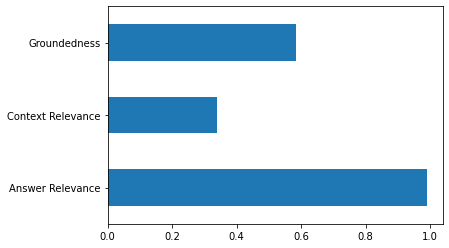

In [56]:
df_res[['Answer Relevance',
       'Context Relevance', 'Groundedness']].mean().plot(kind='barh')

In [57]:
df_res.total_cost.sum()

0.0308

In [27]:
# launches on http://localhost:8501/
tru.run_dashboard()

Starting dashboard ...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://10.38.173.10:8501 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

## Sentece window retrieval

In [34]:
sentence_index = build_sentence_window_index(
    document,
    llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="sentence_index"
)

sentence_window_engine = get_sentence_window_query_engine(sentence_index)

In [35]:
tru = Tru()

tru.reset_database()

tru_recorder_sentence_window = get_prebuilt_trulens_recorder(
    sentence_window_engine,
    app_id = "Sentence Window Query Engine"
)

In [36]:
for question in eval_questions:
    with tru_recorder_sentence_window as recording:
        response = sentence_window_engine.query(question)
        print(question)
        print(str(response))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Millega tegeleb advokatuur? Vasta eesti keeles
Advokatuur tegeleb advokaatide kutsetegevuse korraldamisega, sealhulgas riigi õigusabi osutamise korraldamisega, advokatuuri liikmeks vastuvõtmise tingimuste ja nõuete kehtestamisega, advokatuuri liikmete tegevuse järelevalvega ning advokatuuri liikmetele nimetuste ja emeriitadvokaadi staatuse andmisega.
Kuidas saadakse advokaadiks? Vasta eesti keeles
Advokaadiks saamiseks tuleb sooritada advokaadieksamid, mis koosnevad vandeadvokaadi abi eksamist ja vandeadvokaadieksamist. Advokaadieksam korraldatakse vajaduse järgi, kuid vähemalt üks kord aastas. Eksami toimumise aja ja koha määrab kutsesobivuskomisjon. Advokaadieksam v

In [37]:
records, feedback = tru.get_records_and_feedback(app_ids=[])

In [41]:
df_res_sent_wind=records.copy()

In [42]:
df_res_sent_wind[['input','output','Answer Relevance',
       'Context Relevance', 'Groundedness', 'total_cost']]

,input,output,Answer Relevance,Context Relevance,Groundedness,total_cost
0,"""Millega tegeleb advokatuur? Vasta eesti keeles""","""Advokatuur tegeleb advokaatide kutsetegevuse korraldamisega, sealhulgas riigi \u00f5igusabi osutamise korraldamisega, advokatuuri liikmeks vastuv\u00f5tmise tingimuste ja n\u00f5uete kehtestamisega, advokatuuri liikmete tegevuse j\u00e4relevalvega ning advokatuuri liikmetele nimetuste ja emeriitadvokaadi staatuse andmisega.""",1.0,0.1,0.600000,0.01090
1,"""Kuidas saadakse advokaadiks? Vasta eesti keeles""","""Advokaadiks saamiseks tuleb sooritada advokaadieksamid, mis koosnevad vandeadvokaadi abi eksamist ja vandeadvokaadieksamist. Advokaadieksam korraldatakse vajaduse j\u00e4rgi, kuid v\u00e4hemalt \u00fcks kord aastas. Eksami toimumise aja ja koha m\u00e4\u00e4rab kutsesobivuskomisjon. Advokaadieksam v\u00f5ib koosneda suulisest ja kirjalikust osast ning selle t\u00e4psem korraldus on s\u00e4testatud advokatuuri kodukorras.""",1.0,0.4,0.800000,0.01003
2,"""Mis vahel on vandeadvokaadil ja vandeadvokaadi abil? Vasta eesti keeles""","""Vandeadvokaat on isik, kes on l\u00e4binud advokatuuri juhatuse poolt m\u00e4\u00e4ratud protsessi, saanud vandeadvokaadi kutsenimetuse ja andnud vandeadvokaadivande. Vandeadvokaadi abi on tavaliselt vandeadvokaadi poolt palgatud isik, kes aitab vandeadvokaati tema igap\u00e4evat\u00f6\u00f6s, kuid ei oma vandeadvokaadi staatust ega ole andnud vandeadvokaadivannet. Vandeadvokaadi abi ei pruugi olla l\u00e4binud sama kvalifikatsiooni ja kutseeksameid, mis on n\u00f5utud vandeadvokaadiks saamiseks.""",1.0,0.0,0.333333,0.01253
3,"""Kes teeb j\u00e4relevalvet advokaadi \u00fcle? Vasta eesti keeles""","""Advokaadi tegevuse j\u00e4rele valvab advokatuuri juhatus.""",1.0,0.5,1.000000,0.00854
4,"""Kuidas tasustatakse advokaadi t\u00f6\u00f6d? Vasta eesti keeles""","""Advokaadi t\u00f6\u00f6 tasustamise kohta antud kontekstis otseselt informatsiooni ei ole. Kontekstis on juttu advokaadieksamist ja tasust, kuid see viitab eksami sooritamise tasule, mitte advokaadi t\u00f6\u00f6 tasustamisele. Advokaadi t\u00f6\u00f6 tasustamise kohta tuleks vaadata teisi seaduse s\u00e4tteid v\u00f5i advokaadib\u00fcroo kehtestatud tasustamisp\u00f5him\u00f5tteid.""",0.4,0.0,0.000000,0.01002
5,"""Millised organid on advokatuuris? Vasta eesti keeles""","""Advokatuuri organid on \u00fcldkogu, juhatus, esimees, revisjonikomisjon, aukohus ja kutsesobivuskomisjon.""",1.0,1.0,1.000000,0.00570
6,"""Millega tegeleb kutsesobivuskomisjon? Vasta eesti keeles""","""Kutsesobivuskomisjon tegeleb j\u00e4rgmiste \u00fclesannetega:\n\n1) Eksamineerib advokatuuri astuda soovijaid ja advokaadikutse taotlejaid.\n2) Viib l\u00e4bi sobivustesti v\u00e4lisriigis omandatud kutsekvalifikatsiooni kohta.\n3) Hindab perioodiliselt v\u00f5i juhatuse \u00fclesandel advokaatide kutsesobivust.\n4) Viib l\u00e4bi vestluse isikuga, kes on esitanud avalduse astuda advokatuuri liikmeks.""",1.0,0.5,NaN,0.01268
7,"""Millised on vandeadvokaadi kohustused? Vasta eesti keeles""","""Vandeadvokaadi kohustused h\u00f5lmavad Eesti Vabariigi p\u00f5hiseaduslikule korrale ustavaks j\u00e4\u00e4mist ning k\u00f5ikide \u00fclesannete t\u00e4itmist, milleks vandeadvokaadikutse teda kohustab.""",1.0,0.1,NaN,0.00728
8,"""Miilised asjad peab advokaat saladuses hoidma? Vasta eesti keeles""","""Advokaat peab saladuses hoidma talle \u00f5igusteenust osutades teatavaks saanud andmeid, tema poole \u00f5igusteenuse saamiseks p\u00f6\u00f6rdumist ja \u00f5igusteenuse eest makstud tasu suurust. Kohustus ei ole ajaliselt piiratud ja kehtib ka p\u00e4rast advokaaditegevuse l\u00f5ppemist. Kohustus kehtib ka advokaadib\u00fcroo t\u00f6\u00f6taja ja advokatuuri t\u00f6\u00f6taja kohta ning selle avaliku teenistuja kohta, kellele on advokaadi kutsesaladus teatavaks saanud teenistuskohustusi t\u00e4ites.""",NaN,NaN,NaN,0.01200


<AxesSubplot:>

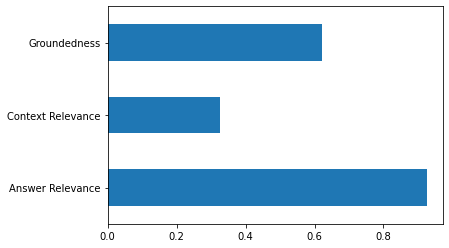

In [43]:
df_res_sent_wind[['Answer Relevance',
       'Context Relevance', 'Groundedness']].mean().plot(kind='barh')

In [44]:
df_res_sent_wind.total_cost.sum()

0.08968

## Save

In [45]:
type(df_res_sent_wind)

pandas.core.frame.DataFrame

In [47]:
df_res_sent_wind.to_excel('data/results/advokatuur_sentence_window_retrieval_gpt4.xlsx', index=False)